# Creating My Shop-by-Style Deep Learning Model on PyTorch

<i> This notebook can be ran on any SageMaker notebook instance type. Run the notebook in the following tested regions: us-west-2, us-east-2, eu-west-1, ap-souteast-2, or ap-northeast-1. You may need to modify the configurations in the code if you choose to run the notebook elsewhere, and isn't recommended. </i>

## Contents

1. [Background](#Background)
2. [Setup](#Setup)
3. [Data](#Data)
4. [Train](#Train)
5. [Deploy](#Real-time-Inference)
6. [Tuning](#Automatic-Model-Tuning) 
7. [Batch Inference](#Programmatic-Batch-Inference)

---

## Background

In this notebook you will build a model to measure the similarity between products from the Zappos product catalog. This notebook uses the [UT Zappos50k](http://vision.cs.utexas.edu/projects/finegrained/utzap50k/) data set provided by University of Texas at Austin. The data has been processed and was scraped off the Zappos.com website, and is intended for non-commerical use.

In this example, we will leverage a CNN based siamese network to learn the similarity function between the products in the catalog. The model is built on PyTorch and trained on SageMaker, and uses transfer learning techniques to leverage pre-trained ResNet models. Finally, the notebook demonstrates how to use SageMaker's Batch Inference functionality to produce a batch of similiarity measures between images using the trained siamese network.

For more information about the PyTorch in SageMaker, please visit [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-containers) and [sagemaker-python-sdk](https://github.com/aws/sagemaker-python-sdk) Github repositories.

---

## Setup

Let's start by creating a SageMaker session and specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See [the documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the sagemaker.get_execution_role() with appropriate full IAM role arn string(s).


In [4]:
import os
import sagemaker
import boto3

SOURCE_DIR='source/similarity'
WORKING_DIR = os.getcwd()

sagemaker_session = sagemaker.Session()

SAGEMAKER_BUCKET = sagemaker_session.default_bucket()
SAGEMAKER_BUCKET_PREFIX = '/sagemaker/DEMO-pytorch-siamese-network/data'

role = sagemaker.get_execution_role()
DATA_S3URI = "s3://"+SAGEMAKER_BUCKET+SAGEMAKER_BUCKET_PREFIX
AWS_REGION = boto3.session.Session().region_name

print("Your region: "+AWS_REGION)
print("Your SageMaker bucket: "+SAGEMAKER_BUCKET)
print("Your current working directory: "+WORKING_DIR)
print("Your training data location: " + DATA_S3URI)

Your region: us-west-2
Your SageMaker bucket: sagemaker-us-west-2-803235869972
Your current working directory: /home/ec2-user/SageMaker
Your training data location: s3://sagemaker-us-west-2-803235869972/sagemaker/DEMO-pytorch-siamese-network/data


## Data

The original dataset can be downloaded from [UT Zappos50k](http://vision.cs.utexas.edu/projects/finegrained/utzap50k/). The dataset has been made available at the following S3 bucket to offload the original site.

In [5]:
DOWNLOAD_S3URI = "s3://reinvent2018-sagemaker-pytorch"

Let's preview one of the images from the data set.

In [7]:
%%bash -s "$DOWNLOAD_S3URI" "$WORKING_DIR"

mkdir -p $2/ut-zap50k-images-square/Boots/Knee\ High/Anne\ Klein/
aws s3 cp $1/data/raw/Boots/Knee\ High/Anne\ Klein/8059298.310.jpg $2/ut-zap50k-images-square/Boots/Knee\ High/Anne\ Klein/

download: s3://reinvent2018-sagemaker-pytorch/data/raw/Boots/Knee High/Anne Klein/8059298.310.jpg to ut-zap50k-images-square/Boots/Knee High/Anne Klein/8059298.310.jpg


<i> Run the cell below again if you don't see the image after the first run.</i>

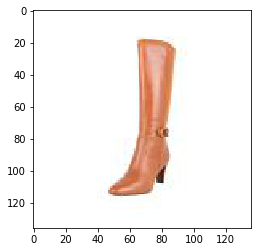

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open(os.path.join(WORKING_DIR,"ut-zap50k-images-square/Boots/Knee High/Anne Klein/8059298.310.jpg"))
plt.imshow(img)

### Uploading the data to S3

We are going to transfer a subset of the Zappos50k dataset over to the default SageMaker bucket in your account. Training on the entire dataset will take hours on GPU as it involves training on a very large dataset of image pair combinations. The goal of this notebook is to demonstrate the process by training on a small subet of the images. 

All the images, processed inputs, and indexes for the entire dataset are publicly shared in the same S3 download location if you wish to experiment on the entire dataset. [Utility scripts](https://github.com/dylan-tong-aws/pytorch-image-similarity/blob/master/notebooks/pytorch_siamese_network_utils.ipynb) have also been made public for you to leverage if you wish to generate your own indexes and pre-processed dataset (npy tensors). 

This notebook works with a subset of sample images for the purpose of learning. The goal is to give you a sense of the experience involved in the training and inference process. You can easily modify the code in this notebook afterwards to work with a large set of the data if you wish.

In [11]:
import time
import pandas as pd

SAMPLE_TRAINING_IMG_PATHS = "sample_training_images.csv"
os.system("aws s3 cp "+DOWNLOAD_S3URI+"/data/sample/"+SAMPLE_TRAINING_IMG_PATHS + " "+WORKING_DIR)
df = pd.read_csv(os.path.join(WORKING_DIR,SAMPLE_TRAINING_IMG_PATHS), header=None, usecols=[0], names=['img'])
IMG_PATHS = df['img'].tolist()

start = time.time()

for paths in IMG_PATHS :
    esc_path = paths.replace(' ','\ ')
    os.system('aws s3 sync ' + (DOWNLOAD_S3URI+"/data/raw/"+esc_path) +
              ' '+ DATA_S3URI+'/'+esc_path +
              ' --quiet --source-region us-west-2 --region '+ AWS_REGION)

end = time.time()
print("Sync completed in "+ str(int(end - start))+" seconds")

Sync completed in 7 seconds


### PyTorch DataSet indexes

Now we copy over index files that have been generated for you. These indexes will be used by the training script to locate selected images during training.

The script expects indexes named as follows for the training and test sets respectively:
-  zappos50k-tuples-index-train.csv
-  zappos50k-tuples-index-test.csv

In [12]:
%%bash -s "$DOWNLOAD_S3URI" "$DATA_S3URI" "$AWS_REGION"

aws s3 cp $1/index/zappos50k-partial-tuples-index-test.csv $2/ --source-region us-west-2 --region $3
aws s3 cp $1/index/zappos50k-partial-tuples-index-train.csv $2/ --source-region us-west-2 --region $3

aws s3 mv $2/zappos50k-partial-tuples-index-train.csv $2/zappos50k-tuples-index-train.csv --quiet
aws s3 mv $2/zappos50k-partial-tuples-index-test.csv $2/zappos50k-tuples-index-test.csv  --quiet

copy: s3://reinvent2018-sagemaker-pytorch/index/zappos50k-partial-tuples-index-test.csv to s3://sagemaker-us-west-2-803235869972/sagemaker/DEMO-pytorch-siamese-network/data/zappos50k-partial-tuples-index-test.csv
copy: s3://reinvent2018-sagemaker-pytorch/index/zappos50k-partial-tuples-index-train.csv to s3://sagemaker-us-west-2-803235869972/sagemaker/DEMO-pytorch-siamese-network/data/zappos50k-partial-tuples-index-train.csv


### Pre-trained model artifacts

Next, we copy over the artifacts for a pre-trained version of the model that we'll be creating in the following steps. This pre-trained model has been trained on the entire data set with a training algorithm that is slightly different from the one used in this notebook to adapt to the larger training set. Reference the [public code here for details](https://github.com/dylan-tong-aws/pytorch-image-similarity/blob/master/src/similarity/siamese2.py). During the inference stages, we'll use the pre-trained model to obtain better results than the example model that you'll create for the purpose of learning the process.

In [13]:
MODELS_S3URI = "s3://"+SAGEMAKER_BUCKET+'/sagemaker/DEMO-pytorch-siamese-network/model/output'
SOURCE_S3URI = "s3://"+SAGEMAKER_BUCKET+'/sagemaker/DEMO-pytorch-siamese-network/model/source'
MODEL_VERSION = 6

In [16]:
%%bash -s "$DOWNLOAD_S3URI" "$MODELS_S3URI" "$AWS_REGION" "$MODEL_VERSION" "$SOURCE_S3URI"

START_TIME=$SECONDS

aws s3 sync $1/models/v$4 $2 --source-region us-west-2 --region $3 --quiet
aws s3 cp $1/source/similarity/sourcedir.tar.gz $5/sourcedir.tar.gz --source-region us-west-2 --region $3 --quiet

DURATION=$(($SECONDS - $START_TIME))

echo
echo Sync completed in $DURATION seconds
echo
echo Location of your pre-trained model artifacts: $2/model.tar.gz
echo
echo Location of your pre-trained model source code: $5/sourcedir.tar.gz


Sync completed in 2 seconds

Location of your pre-trained model artifacts: s3://sagemaker-us-west-2-803235869972/sagemaker/DEMO-pytorch-siamese-network/model/output/model.tar.gz

Location of your pre-trained model source code: s3://sagemaker-us-west-2-803235869972/sagemaker/DEMO-pytorch-siamese-network/model/source/sourcedir.tar.gz


## Train

We need to provide a training script that can run on the SageMaker platform. The training script is very similar to a training script you might run outside of SageMaker, but you can access useful properties about the training environment through various environment variables.

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to model_dir so that it can be hosted later. Hyperparameters are passed to your script as arguments and can be retrieved with an argparse.ArgumentParser instance.

In the following steps, scripts are provided to build and train the following model:

### Deep Siamese Network Architecture

<img src="https://s3-us-west-2.amazonaws.com/reinvent2018-sagemaker-pytorch/web/siamese_network_diag.jpg" width="65%" height="65%" align="left"/>

### Preview Results

Before we build and train our model, let's preview some example results from a trained model.

Download a subset of the Zappos50K dataset over to our Notebook instance along with some inference results generated from a pre-trained model.

In [18]:
import os

SAMPLES_S3URI = DOWNLOAD_S3URI+'/data/sample/'

SAMPLE_IMAGES_FILE = "zappos50k-sample-images.zip"
SAMPLE_IMAGES_S3URI = SAMPLES_S3URI+SAMPLE_IMAGES_FILE

OUTPUT_SAMPLES_FILE = "sample-v2-batch-out.zip"
OUTPUT_SAMPLES_S3URI = SAMPLES_S3URI+"batch-workshop/out/"+OUTPUT_SAMPLES_FILE

print('Downloading sample test images... \n')
os.system("aws s3 cp "+SAMPLE_IMAGES_S3URI+" "+WORKING_DIR+" --source-region us-west-2 --region "+AWS_REGION)
os.system("unzip ./"+SAMPLE_IMAGES_FILE)

sample_images_fp = os.path.join(WORKING_DIR,SAMPLE_IMAGES_FILE)
if os.path.isfile(sample_images_fp) :
    print("Samples test images were successfully downloaded to: "+sample_images_fp)
else :
    print("Failed to download sample test images \n")

print('\nDownloading sample inference results... \n')
os.system("aws s3 cp "+OUTPUT_SAMPLES_S3URI+" "+WORKING_DIR+" --source-region us-west-2 --region "+AWS_REGION)
os.system("unzip ./"+OUTPUT_SAMPLES_FILE)

sample_inferences_fp = os.path.join(WORKING_DIR,OUTPUT_SAMPLES_FILE)
if os.path.isfile(sample_inferences_fp) :
    print("Samples inference results were successfully downloaded to: "+sample_inferences_fp)
else :
    print("Failed to download sample inference results")


Samples test images were successfully downloaded to: /home/ec2-user/SageMaker/zappos50k-sample-images.zip


Samples inference results were successfully downloaded to: /home/ec2-user/SageMaker/sample-v2-batch-out.zip


Now let's load the sample outputs into Pandas dataframes...

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

LOCAL_OUTPUT_DIR = os.path.join(WORKING_DIR,'out')
LOCAL_DATA_DIR = os.path.join(WORKING_DIR,'data')
SAMPLE_PRODUCTS = []

def load_sample_outputs() :
    i = 0
    for (root, _, files) in os.walk(LOCAL_OUTPUT_DIR) :
        for f in files :
            fp = os.path.join(root,f)
            df = pd.read_csv(fp, header=None, names=['img','sim'])
            p=fp.replace(LOCAL_OUTPUT_DIR,'').replace('.csv','')
            print(str(i)+": "+p)
            SAMPLE_PRODUCTS.append({"n":p, "sim": df.sort_values(['sim'], ascending=True)})
            i = i+1

            import matplotlib.pyplot as plt
    
def display_similiar_products(product_info) :
    count = 0
    columns = 7
    BATCHES_TO_DISPLAY = 3

    fig = plt.figure(figsize=(columns*2, BATCHES_TO_DISPLAY*3))
    fig.subplots_adjust(wspace=.1)

    products = product_info['sim']
    print(product_info['n'])
    for (index, row) in products[0:columns*BATCHES_TO_DISPLAY].iterrows() :

        count += 1
        ax = fig.add_subplot(BATCHES_TO_DISPLAY, columns, count)   
        ax.set_title(round(row['sim'],5))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.imshow(plt.imread(os.path.join(LOCAL_DATA_DIR,row['img'])))
        
    plt.show()

load_sample_outputs()

0: /Sandals/Heel/Fly Flot/7418709.9
1: /Shoes/Oxfords/Bass/7563706.3
2: /Shoes/Oxfords/Rockport/7996677.6194
3: /Shoes/Oxfords/Calvin Klein/7943176.325
4: /Boots/Over the Knee/Calvin Klein Collection/8005712.365488
5: /Boots/Knee High/Anne Klein/8032745.10224
6: /Boots/Knee High/Ariat/7992449.16158


### Visualize Samples

The output from the cell above lists 7 products, which have pre-generated inferences. Run the cell below to view visually similar products. The first image is the product we're querying, and the products that follow are ordered by similarity (ordered from left to right and top to bottom in descending similarity). Change the index value from 0-6 if you like to preview other products.

The images displayed are in ascending order of similarity (left to right and top to bottom). The value above the images represent an unnormalized similarity score. The first image is the product we're using to query for other stylistically similar products. It's value isn't exactly zero due to floating-point precision and the fact that this model represents a generalized approximation.

/Shoes/Oxfords/Calvin Klein/7943176.325


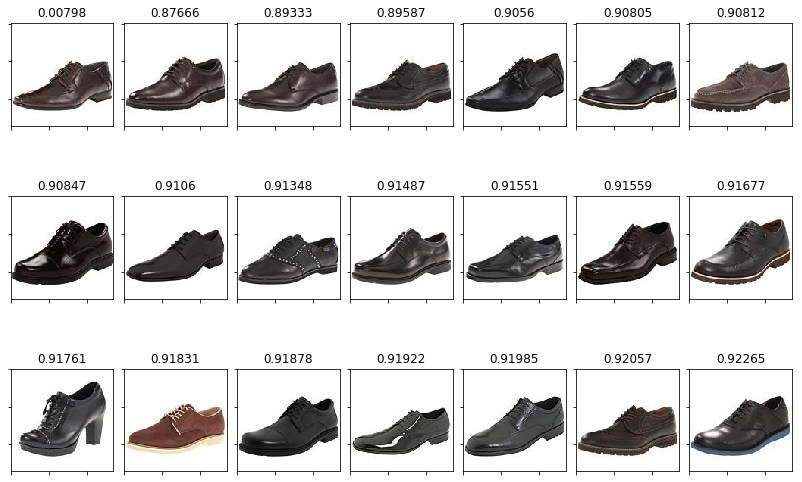

In [30]:
display_similiar_products(SAMPLE_PRODUCTS[3])

### Download the provided scripts

Let's move on to building and training a model. First, we download the scripts:

-  cnn.py: this script implements a siamese network in PyTorch. It uses a pre-trained ResNet model, and replaces the last layer with a dense layer with the number of dimensions as specified by class parameters. All layers except the last have been frozen for training.

-  siamese.py: contains all the training logic. The siamese network takes batches of image pairs, uses the CNN to extract salient features and vectorize the images, and minimizes a contrastive loss function according to the L1 distances between the image vectors and the provided labels.

-  requirements.txt: describes the dependencies that are required by the scripts that aren't pre-installed on the SageMaker PyTorch container. 

In [31]:
%%bash -s "$DOWNLOAD_S3URI" "$SOURCE_DIR" "$AWS_REGION"

mkdir -p $2
aws s3 cp $1/$2/cnn.py ./$2 --source-region us-west-2 --region $3
aws s3 cp $1/$2/siamese.py ./$2 --source-region us-west-2 --region $3
aws s3 cp $1/$2/requirements.txt ./$2 --source-region us-west-2 --region $3

download: s3://reinvent2018-sagemaker-pytorch/source/similarity/cnn.py to source/similarity/cnn.py
download: s3://reinvent2018-sagemaker-pytorch/source/similarity/siamese.py to source/similarity/siamese.py
download: s3://reinvent2018-sagemaker-pytorch/source/similarity/requirements.txt to source/similarity/requirements.txt


### Model Script

Run the cell below if you like to view the script for the PyTorch model.

In [32]:
!pygmentize 'source/similarity/cnn.py'

import torch
import torch.nn as nn
import torchvision.models as models

class CNN(nn.Module):

    COSINE_SIMILARITY = 0
    L1_SIMILARITY = 1
    L2_SIMILARITY = 2
    PARAM_DISTANCE_DECAY_RATE = 0.5
    
    @staticmethod
    def exp_manhattan_distance(v1,v2) :

        d = torch.pow(nn.functional.pairwise_distance(v1,v2,1),CNN.PARAM_DISTANCE_DECAY_RATE)
        return 1.0 - torch.exp(-d)

    @staticmethod
    def exp_euclidian_distance(v1,v2) :
        d = torch.pow(nn.functional.pairwise_distance(v1,v2,2),CNN.PARAM_DISTANCE_DECAY_RATE)
        return 1.0 - torch.exp(-d)

    @staticmethod
    def inv_cosine_similarity(v1,v2) :
        return torch.abs(torch.abs(nn.functional.cosine_similarity(v1,v2)) - 1.0)

    sim_fns = [inv_cosine_similarity,  exp_manhattan_distance, exp_euclidian_distance]
    sim_fn = sim_fns[L1_SIMILARITY]
    
    def build_model(self, dims, v):
        
        if v == 18:
            cnn = models.resnet18(pretrained=True)
        elif v == 34:
           

### Training Script

Run the cell below if you like to view the script for training the siamese network on PyTorch. 

In [33]:
!pygmentize 'source/similarity/siamese.py'

import argparse
import os
import sys
import time
import copy
import math
import warnings
import csv
import logging

from PIL import Image
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim

from cnn import CNN as cnn

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))
    
parser = argparse.ArgumentParser(description='PyTorch CNN Siamese Network')

# Hyperparameters sent by the client are passed as command-line arguments to the script.
parser.add_argument('--batch-size', type=int, default=64, help='mini batch size')
parser.add_argument('--epochs', type=int, default=10, help='number of epochs')
parser.add_argument('--learning-rate', type=float, default=1e-4, help='learning rate')
parser.add_argument('--similarity-dims', type=int, default=64, 
                    help='the number o

### Hyperparameters

Next we define the hyperparameters for our training job. The configurations are set to train on a single epoch. In practice, you'll train for a longer period to obtain better results. In this lab, our goal is to be familiarized with the process.

In [34]:
PARAM_EPOCHS = 1
PARAM_BATCH_SIZE= 64
PARAM_LR = 1e-6
PARAM_SIMILARITY_DIMS = 64
PARAM_SIM_MARGIN = 0.03
PARAM_OPTIMIZER = 'Adam'
PARAM_BEST_MODEL_METRIC = 'test-loss'

HYPERPARAMETERS={
                    'epochs': PARAM_EPOCHS,
                    'batch-size': PARAM_BATCH_SIZE,
                    'learning-rate': PARAM_LR,
                    'similarity-dims': PARAM_SIMILARITY_DIMS,
                    'similarity-margin': PARAM_SIM_MARGIN,
                    'optimizer': PARAM_OPTIMIZER,
                    'best-model-metric' : PARAM_BEST_MODEL_METRIC
                }

### Define the PyTorch Estimator

The provided custom PyTorch training script can now be trained on SageMaker training servers without further setup. A PyTorch estimator needs to be instantiated as shown below specifying the training script to run, hyperparameters, and the infrastructure to use.

In [35]:
from sagemaker.pytorch import PyTorch

def default_training_instancetype(region) :
    
    inst_map = {
        'us-west-2': 'ml.p3.2xlarge',
        'us-east-2': 'ml.p3.2xlarge',
        'eu-west-1': 'ml.p3.2xlarge',
        'ap-southeast-2': 'ml.p2.xlarge',
        'ap-northeast-1': 'ml.p3.2xlarge'
    }
    
    try :
        
        default = inst_map[region]
        
    except :
        print("This notebook wasn't tested in the region you're running in! Switch regions, or modify the code at your own discretion.")
        
    return default
    
estimator = PyTorch(entry_point="siamese.py",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type=default_training_instancetype(AWS_REGION),
                    source_dir=SOURCE_DIR,
                    hyperparameters=HYPERPARAMETERS)

### Run the Estimator

The training job is started simply by calling fit() on the estimator, and specifying the location of our training data and indexes. Note that you could specify a different location for your test set, but this isn't necessary as the provided indexes are used to seperate the training and test sets within the provided data corpus.  

    If you train the model without changing the dataset subset or the default parameters provided, the training will complete in 10-20 minutes using a ml.p3.2xlarge.

In [36]:
estimator.fit({'train':DATA_S3URI})

INFO:sagemaker:Creating training-job with name: sagemaker-pytorch-2019-01-12-00-29-03-785


2019-01-12 00:29:04 Starting - Starting the training job...
2019-01-12 00:29:08 Starting - Launching requested ML instances......
2019-01-12 00:30:09 Starting - Preparing the instances for training......
2019-01-12 00:31:17 Downloading - Downloading input data
2019-01-12 00:31:17 Training - Downloading the training image...
2019-01-12 00:31:56 Training - Training image download completed. Training in progress..
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2019-01-12 00:31:57,390 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2019-01-12 00:31:57,415 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2019-01-12 00:31:57,424 sagemaker_pytorch_container.training INFO     Invoking user training script.
2019-01-12 00:31:57,645 sagemaker-containers INFO     Module siamese does not provide a setup.py. 
Generating setup.py
2019-01-12 00:31:57,645 sagemak


2019-01-12 00:38:15 Uploading - Uploading generated training model
2019-01-12 00:39:05 Completed - Training job completed
Billable seconds: 476


## Real-time Inference

Once you have a trained model, you probably want to do some testing and evaluation on the model. Deploying a SageMaker model for real-time inference might be useful at this stage. Let's create an endpoint that takes two image tensors and returns the similarity measure between the images as a json output.

First, download the inference script, which will be used as the entry point for a real-time inference model.

In [37]:
%%bash -s "$DOWNLOAD_S3URI" "$SOURCE_DIR"
mkdir -p $2
aws s3 cp $1/$2/inference.py ./$2

download: s3://reinvent2018-sagemaker-pytorch/source/similarity/inference.py to source/similarity/inference.py


Run the cell below if you like to view the real-time inference script.

In [ ]:
!pygmentize 'source/similarity/inference.py'

Run this cell to set a name for our real-time inference endpoint.

In [40]:
RT_ENDPOINT_NAME = "rt-zappos50k-siamese-cnn"

### Deploy Endpoint

Run the following code to register a model, and deploy our endpoint. Note that the configurations utilize the pre-trained model that was downloaded previously.

The model uses the inference.py script as it's entry point.

In [41]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import RealTimePredictor, npy_serializer, json_deserializer

rtModel = PyTorchModel(model_data=MODELS_S3URI+'/model.tar.gz', 
                            role=role,
                            framework_version='0.4.0',
                            entry_point='inference.py',
                            source_dir=SOURCE_DIR)

rtPredictor = rtModel.deploy(instance_type='ml.c5.xlarge', 
                                   initial_instance_count=1,
                                   endpoint_name=RT_ENDPOINT_NAME)
                      
rtPredictor = RealTimePredictor(endpoint=RT_ENDPOINT_NAME,
                                 serializer=npy_serializer,
                                 deserializer= json_deserializer)

INFO:sagemaker:Creating model with name: sagemaker-pytorch-2019-01-12-00-44-16-934
INFO:sagemaker:Creating endpoint with name rt-zappos50k-siamese-cnn


-------------------------------------------------------------------!

### Use an Existing Endpoint

During development you may go through a few training cycles. Typically you'll build and train the model locally, run a remote training job for larger scale training, and perhaps do some manual model evaluation with the help of a real-time endpoint. 

If you've already deployed an real-time endpoint previously, you can run the following code snippet instead of the prevous snippet to acquire a reference to the existing endpoint instead of deploying a new one.

In [42]:
from sagemaker.predictor import RealTimePredictor, npy_serializer, json_deserializer
        
rtPredictor = RealTimePredictor(endpoint=RT_ENDPOINT_NAME,
                                 serializer=npy_serializer,
                                 deserializer= json_deserializer)

### Test the Endpoint

First, run the cell below to initialize some constants and utility functions

In [71]:
from torchvision import transforms
from PIL import Image

TRANSFORMATIONS = \
transforms.Compose([
    transforms.Resize(224), \
    transforms.ToTensor(), \
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) \
])


#PRODUCT = "Boots/Knee High/Anne Klein/8059298.310.jpg"
#PRODUCT = "Shoes/Oxfords/Bass/7563706.3.jpg"
#PRODUCT = "Shoes/Oxfords/Rockport/7996677.6194.jpg"
#PRODUCT = "Shoes/Oxfords/Calvin Klein/7943176.325.jpg"
#PRODUCT = "Boots/Over the Knee/Calvin Klein Collection/8005712.365488.jpg"
#PRODUCT = "Boots/Knee High/Anne Klein/8032745.10224.jpg"
PRODUCT = "Boots/Knee High/Ariat/7992449.16158.jpg"
#PRODUCT = "Sandals/Heel/Fly Flot/7418709.9.jpg"
#PRODUCT = Shoes/Oxfords/Bass/7563706.3.jpg"

IMG1_LOC = os.path.join(WORKING_DIR,"data/"+PRODUCT)
ZAPPOS50K_SAMPLE_INDEX = "zappos50k-partial-index.csv"

os.system("aws s3 cp "+DOWNLOAD_S3URI+"/index/"+ZAPPOS50K_SAMPLE_INDEX+" "+
      os.path.join(WORKING_DIR,ZAPPOS50K_SAMPLE_INDEX) + 
      " --source-region us-west-2 --region "+ AWS_REGION)

def getImageTensor(img_path, transform):
    
    image = Image.open(img_path)
    image_tensor = transform(image)
        
    return image_tensor

Now let's run a quick test comparing an image with itself.

In [72]:
import numpy as np

img1 = getImageTensor(IMG1_LOC, TRANSFORMATIONS)
imgPair= np.vstack((img1,img1))
res= rtPredictor.predict(imgPair)

print(res)

{'similarity': 0.00796806812286377}


Run the following snippet to display the similar products for our selection in order of most similar.

This is a real-time endpoint and the following code will make api calls a few hundred times comparing the selected product (image) to a few hundred others to capture similarity measures. It will take 5-6 minutes to execute. In practice, you can scale-out (optionally, with auto-scaling) to increase the throughput on the endpoint.

<i> Note that inference is being run on only a few hundred images veresus the 50K+ images in the full data set. </i>

In [73]:
import numpy as np
import pandas as pd

img1 = getImageTensor(IMG1_LOC, TRANSFORMATIONS)
df = pd.read_csv(ZAPPOS50K_SAMPLE_INDEX, header=None, usecols=[0], names=['img'])    

for (i,r) in df.iterrows() :
    
    img2 = getImageTensor(LOCAL_DATA_DIR+'/'+r['img'], TRANSFORMATIONS)
    imgPair= np.vstack((img1,img2))
    res= rtPredictor.predict(imgPair)
    df.at[i,'sim'] = float(res['similarity'])

df= df.sort_values(['sim'], ascending=True)

pd.set_option("display.max_rows",10)
display(df)

,img,sim
22,Boots/Knee High/Ariat/7992449.16158.jpg,0.007968
4,Boots/Knee High/Anne Klein/8059298.310.jpg,0.867596
11,Boots/Knee High/Anne Klein/8032825.310.jpg,0.883828
9,Boots/Knee High/Anne Klein/8032743.310.jpg,0.891191
3,Boots/Knee High/Anne Klein/8032745.310.jpg,0.896389
...,...,...
172,Sandals/Heel/Onex/7622650.18.jpg,0.971113
173,Sandals/Heel/Onex/7622623.18.jpg,0.971791
174,Sandals/Heel/Onex/7622629.10881.jpg,0.973113
199,Shoes/Oxfords/Rockport/7996596.103.jpg,0.973807


### Visualize

Let's visualize the results from our sampling of a few hundred images. Note that you'll see better results if inference is ran on the entire product catalog of 50k+ images.

/home/ec2-user/SageMaker/data/Boots/Knee High/Ariat/7992449.16158.jpg


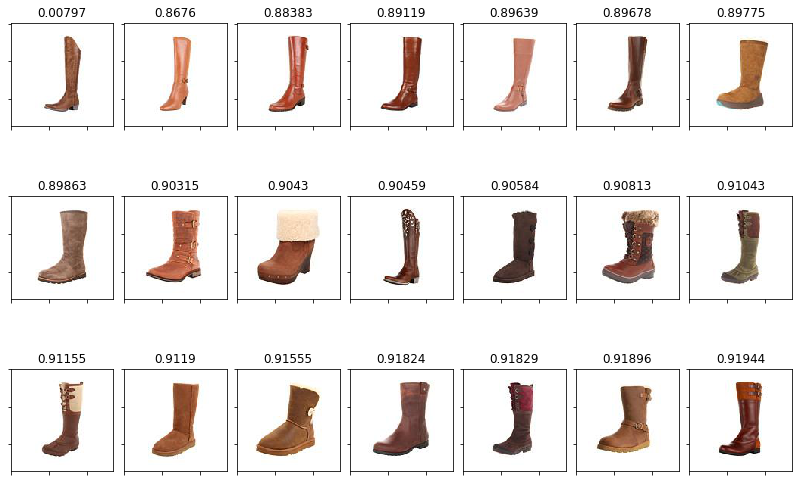

In [74]:
display_similiar_products({"n": IMG1_LOC, "sim": df})

## Automatic Model Tuning 

Hyperparameters can have substantial effect on the performance and outcome of your model training. A training process traditionally involves a strategy for exploring a range of hyperparameter values in search for a combination that delivers optimal results. 

SageMaker offers a capability call Automatic Model Tuning that performs the process of finding optimal hyperparameters for you by running training jobs in parallel for you and using a Bayesian search strategy to narrow down on the optimal combination of hyperparameters. Ultimately, this reduces the amount of training runs compared to basic hyperparameter search strategies like random search that most data scientists typically use to find optimal hyperparameters, and can lead to discovering parameters that lead to superior results.

The snippets below shows how to launch an hyperparameter tuning job programmatically. You are free to change the base hyperparameters and ranges if you wish. The settings below limit the parallel training jobs to one as it is configured to use GPU instances, and by default, AWS accounts only allow you to launch one of these instance types at a time. If your account has been approved for higher limits, and you are prepared to pay for the training time, you can change the parameters to launch multiple instances and jobs running in parallel to speed up the hyperparameter search process. The default sample datasets with the configurations below will require 40-60 minutes per training job, and run up to a maximum of 2 jobs. You can stop the tuning job from the console to end the process prematurely.

Run the cell below to initialize the base hyperparameters and estimator.

In [53]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter

PARAM_EPOCHS = 8
PARAM_BATCH_SIZE= 64
PARAM_LR = 1e-4
PARAM_SIMILARITY_DIMS = 64
PARAM_SIM_MARGIN = 0.03
PARAM_OPTIMIZER = 'Adam'

HYPERPARAMETERS={
                    'epochs': PARAM_EPOCHS,
                    'batch-size': PARAM_BATCH_SIZE,
                    'learning-rate': PARAM_LR,
                    'similarity-dims': PARAM_SIMILARITY_DIMS,
                    'similarity-margin': PARAM_SIM_MARGIN,
                    'optimizer': PARAM_OPTIMIZER
                }

tuned_estimator = PyTorch(entry_point="siamese.py",
                            role=role,
                            framework_version='0.4.0',
                            train_instance_count=1,
                            train_instance_type=default_training_instancetype(AWS_REGION),
                            source_dir=SOURCE_DIR,
                            base_job_name='HPO-pytorch',
                            hyperparameters=HYPERPARAMETERS)

### Define Hyperparameter Ranges

Hyperparameter tuning jobs are different from standard training jobs in the sense that you provide the job information about the range of hyperparameters you like to search. The snippet below demonstrates this idea. In this case, we'll explore multiple settings for the training learning rate, the number of dimensions configured in the last layer of the CNN as well as the type of optimizer to use (Adam vs. plain Stochastic Gradient Descent).

Lastly, an objective metric needs to be defined to determine what is the best model. The model that delivers the best results for the defined objective metric is what is ultimately delivered by the tuning job. The configurations below delivers the model and settings that result in the lowest "average training loss.' You are free to define whatever metric you like. For instance, in many cases, validation accuracy is likely what you're optimizing for.

This hyperparameter process runs up to 2 jobs sequentially. The time required to complete the HPO job will range from 3-6 hours depending on the instance type used. The instance type varies depending on the region you're running this lab in. In practice, you will also run more than 2 jobs, and to speed up the process, you will run multiple jobs in parallel. Running more parallel jobs will require contacting AWs Support to increasing the default soft limit for SageMaker p-family instances on your account. 

In [54]:
from sagemaker.tuner import HyperparameterTuner

HYPERPARAM_RANGES = {
                        'learning-rate': ContinuousParameter(1e-6, 1e-4),
                        'similarity-dims': CategoricalParameter([16,32,64,96,128]),
                        'optimizer': CategoricalParameter(['Adam','SGD'])
                    }

OBJECTIVE_METRIC_NAME = 'average training loss'
METRIC_DEFINITIONS = [{'Name': 'average training loss',
                       'Regex': 'Training set: Average loss: ([0-9\\.]+)'}]

# Configure HyperparameterTuner
tuner = HyperparameterTuner(estimator=tuned_estimator,
                            objective_metric_name = OBJECTIVE_METRIC_NAME,
                            hyperparameter_ranges  = HYPERPARAM_RANGES,
                            metric_definitions = METRIC_DEFINITIONS,
                            max_jobs=2,
                            max_parallel_jobs=1)

# Start hyperparameter tuning job
tuner.fit({'train': DATA_S3URI})

INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-pytorch-190112-0120


### Deploy the Model

You can deploy the best model returned by the tuning job programatically in the same way you would deploy a model produced by a basic training job.

In this case, the model is deployed as a real-time endpoint. Note that the HPO tuning job is deployed asynchronously. The code snippets that follow can't be run until the tuner job ends.

In [55]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import RealTimePredictor, npy_serializer, json_deserializer

TUNED_MODEL_DATA = "s3://"+SAGEMAKER_BUCKET+"/"+tuner.best_training_job()+"/output/model.tar.gz"
RT_TUNED_ENDPOINT_NAME = 'HPO-rt-zappos50k'

tuned_model = PyTorchModel(model_data=TUNED_MODEL_DATA, 
                            role=role,
                            framework_version='0.4.0',
                            entry_point='inference.py',
                            source_dir=SOURCE_DIR)

tuned_predictor = tuned_model.deploy(instance_type='ml.c5.xlarge', 
                                   initial_instance_count=1,
                                   endpoint_name=RT_TUNED_ENDPOINT_NAME)
                      
tuned_predictor = RealTimePredictor(endpoint=RT_TUNED_ENDPOINT_NAME,
                                 serializer=npy_serializer,
                                 deserializer= json_deserializer)

INFO:sagemaker:Creating model with name: sagemaker-pytorch-2019-01-12-06-34-16-780
INFO:sagemaker:Creating endpoint with name HPO-rt-zappos50k


---------------------------------------------------------------!

### Test the Model

Below are some constants and utilities for testing this model. You can change the value of PRODUCT if you like to visualize the similar products for something different from what is set below.

<i> Note that these constants, and utilities were defined previously. They're added here for redundancy in case some users skipped the previous section that deployed a real-time inference endpoint. </i>

In [75]:
from torchvision import transforms
from PIL import Image

TRANSFORMATIONS = \
transforms.Compose([
    transforms.Resize(224), \
    transforms.ToTensor(), \
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) \
])

PRODUCT = "Shoes/Oxfords/Bass/7563706.3.jpg"

IMG1_LOC = os.path.join(WORKING_DIR,"data/"+PRODUCT)
ZAPPOS50K_SAMPLE_INDEX = "zappos50k-partial-index.csv"

os.system("aws s3 cp "+DOWNLOAD_S3URI+"/index/"+ZAPPOS50K_SAMPLE_INDEX+" "+
      os.path.join(WORKING_DIR,ZAPPOS50K_SAMPLE_INDEX) + 
      " --source-region us-west-2 --region "+ AWS_REGION)

def getImageTensor(img_path, transform):
    
    image = Image.open(img_path)
    image_tensor = transform(image)
        
    return image_tensor

### Display the results

Run the following snippet to display the similar products for our selection in order of most similar.

This is a real-time endpoint and the following code will make api calls a few hundred times comparing the selected product (image) to a few hundred others to capture similarity measures. It will take 5-6 minutes to execute.

In [76]:
import numpy as np
import pandas as pd

img1 = getImageTensor(IMG1_LOC, TRANSFORMATIONS)
df = pd.read_csv(ZAPPOS50K_SAMPLE_INDEX, header=None, usecols=[0], names=['img'])    

for (i,r) in df.iterrows() :
    
    img2 = getImageTensor(LOCAL_DATA_DIR+'/'+r['img'], TRANSFORMATIONS)
    imgPair= np.vstack((img1,img2))
    res= tuned_predictor.predict(imgPair)
    df.at[i,'sim'] = float(res['similarity'])

df= df.sort_values(['sim'], ascending=True)

pd.set_option("display.max_rows",10)
display(df)

,img,sim
297,Shoes/Oxfords/Bass/7563706.3.jpg,0.005641
299,Shoes/Oxfords/Bass/7554499.72.jpg,0.848391
182,Shoes/Oxfords/Calvin Klein/7443617.2560.jpg,0.852126
243,Shoes/Oxfords/Rockport/7996724.3.jpg,0.854147
176,Shoes/Oxfords/Calvin Klein/7943176.3.jpg,0.858213
...,...,...
277,Shoes/Oxfords/Bass/7976075.9041.jpg,0.963508
164,Sandals/Heel/Onex/7313933.2044.jpg,0.967729
160,Sandals/Heel/Fly Flot/7418709.585.jpg,0.975828
302,Shoes/Oxfords/Bass/7976075.86183.jpg,0.980418


### Visualize

Let's visualize the results.

* Note that the tuned results probably won't be as good as the provided pre-trained model. The pre-trained model has been trained on the entire Zappos50K data set and on days worth of training time. The training on this lab is only on a subset of the data set. It also uses a [slightly different training algorithm than the one in the lab](https://github.com/dylan-tong-aws/pytorch-image-similarity/blob/master/src/similarity/siamese2.py). 

/home/ec2-user/SageMaker/data/Shoes/Oxfords/Bass/7563706.3.jpg


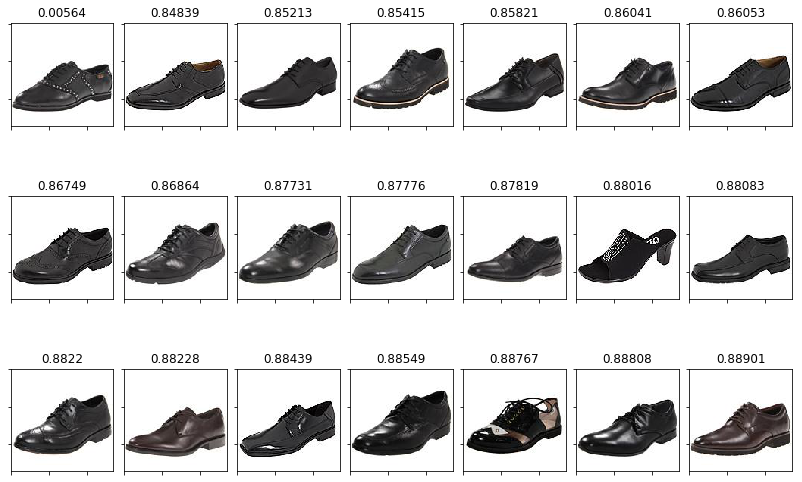

In [77]:
display_similiar_products({"n": IMG1_LOC, "sim": df})

## Programmatic Batch Inference

Similar to other SageMaker features, you have the option to launch a batch inference job from the console, or programatically as demonstrated in the cells below.

Once we have an optimized model, we're ready to run a large scale inference job to obtain similarity scores across our entire data set. This is most efficiently done as a batch inference job.

Run the cell below to download the script for batch inference.

In [59]:
%%bash -s "$DOWNLOAD_S3URI" "$SOURCE_DIR"
mkdir -p $2
aws s3 cp $1/$2/batch.py ./$2

download: s3://reinvent2018-sagemaker-pytorch/source/similarity/batch.py to source/similarity/batch.py


Run the cell below if you like to view the batch inference script.

In [60]:
!pygmentize 'source/similarity/batch.py'

import logging
import json
import os
import torch
import pickle
from cnn import CNN
import numpy as np
import gzip
from io import BytesIO, StringIO

OUTPUT_CONTENT_TYPE = 'text/csv'
INPUT_CONTENT_TYPE = 'application/x-npy'
logger = logging.getLogger(__name__)

image_names = []

def model_fn(model_dir):
    
    model_info = {}
    
    with open(os.path.join(model_dir, 'model_info.pth'), 'rb') as f:
        model_info = torch.load(f)
    
    print('model_info: {}'.format(model_info))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    logger.info('Current device: {}'.format(device))
    model = CNN(similarity_dims=model_info['simililarity-dims'])

    with open(os.path.join(model_dir, 'model.pth'), 'rb') as f:
        model.load_state_dict(torch.load(f))
    
    model.eval()
    logger.info(model)
    return model


def input_fn(request_body, accept=INPUT_CONTENT_TYPE):
    logger.info('Deserializing the generated input.')
    if accept == INPUT_CONTENT

Set some constants

In [62]:
BATCH_INPUT_S3URI = DATA_S3URI+"/batch/in"
BATCH_OUTPUT_S3URI = DATA_S3URI+"/batch/out"
BATCH_MODEL_NAME = "batch-zappos50k-siamese-cnn"
BATCH_INSTANCE_TYPE = 'ml.c5.xlarge'

The batch inference job that we're going to create expects inputs in NPY format. The images have been pre-processed by packing pairs of image tensors in NPY format into gzip files, so that images can be sent to a SageMaker Batch Transform job cluster in batches. 

Pre-processed images have been provided for you. Run the cell to download them to your SageMaker bucket, so that your batch inference job has access to the input data.

As before, this notebook is running the job on a small subset of the full dataset for the sake of demonstration. You always have the option to reconfigure, and pre-process your own dataset to build a full-scale model.

In [63]:
%%bash -s "$DOWNLOAD_S3URI" "$BATCH_INPUT_S3URI" "$AWS_REGION"

start=$SECONDS
aws s3 sync $1/data/sample/batch-workshop/in $2 --quiet --source-region us-west-2 --region $3
duration=$(( SECONDS - start ))

echo sync completed in $duration seconds

sync completed in 2 seconds


### Register a Model for Batch Inference

We need to register a model with SageMaker for the batch inference job. This model uses the batch inference script as the entry point. We'll use the pre-trained model that was downloaded in the previous steps.

In [64]:
from sagemaker.pytorch import PyTorchModel

batchModel = PyTorchModel(model_data=MODELS_S3URI+'/model.tar.gz', 
                            role=role,
                            framework_version='0.4.0',
                            entry_point='batch.py',
                            source_dir=SOURCE_DIR)

batchModel.sagemaker_session = sagemaker_session
container_def = batchModel.prepare_container_def(instance_type=BATCH_INSTANCE_TYPE)
sagemaker_session.create_model(BATCH_MODEL_NAME, role, container_def)

INFO:sagemaker:Creating model with name: batch-zappos50k-siamese-cnn


'batch-zappos50k-siamese-cnn'

### Launch the Batch Inference Job

Now we're ready to run a Batch Inference job. Run the snippet below to launch a batch inference job programmatically.

In [65]:
from sagemaker.transformer import Transformer

transformer = Transformer(model_name=BATCH_MODEL_NAME,
                          instance_count=1,
                          instance_type= BATCH_INSTANCE_TYPE,
                          accept = 'text/csv',
                          output_path=BATCH_OUTPUT_S3URI
                         )
transformer.transform(BATCH_INPUT_S3URI, content_type= 'application/x-npy')

INFO:sagemaker:Creating transform job with name: sagemaker-pytorch-2019-01-12-06-49-43-816
